Average MSE: 0.8700683996187671
Average sensor lifetime (years): 0.11690278787603202


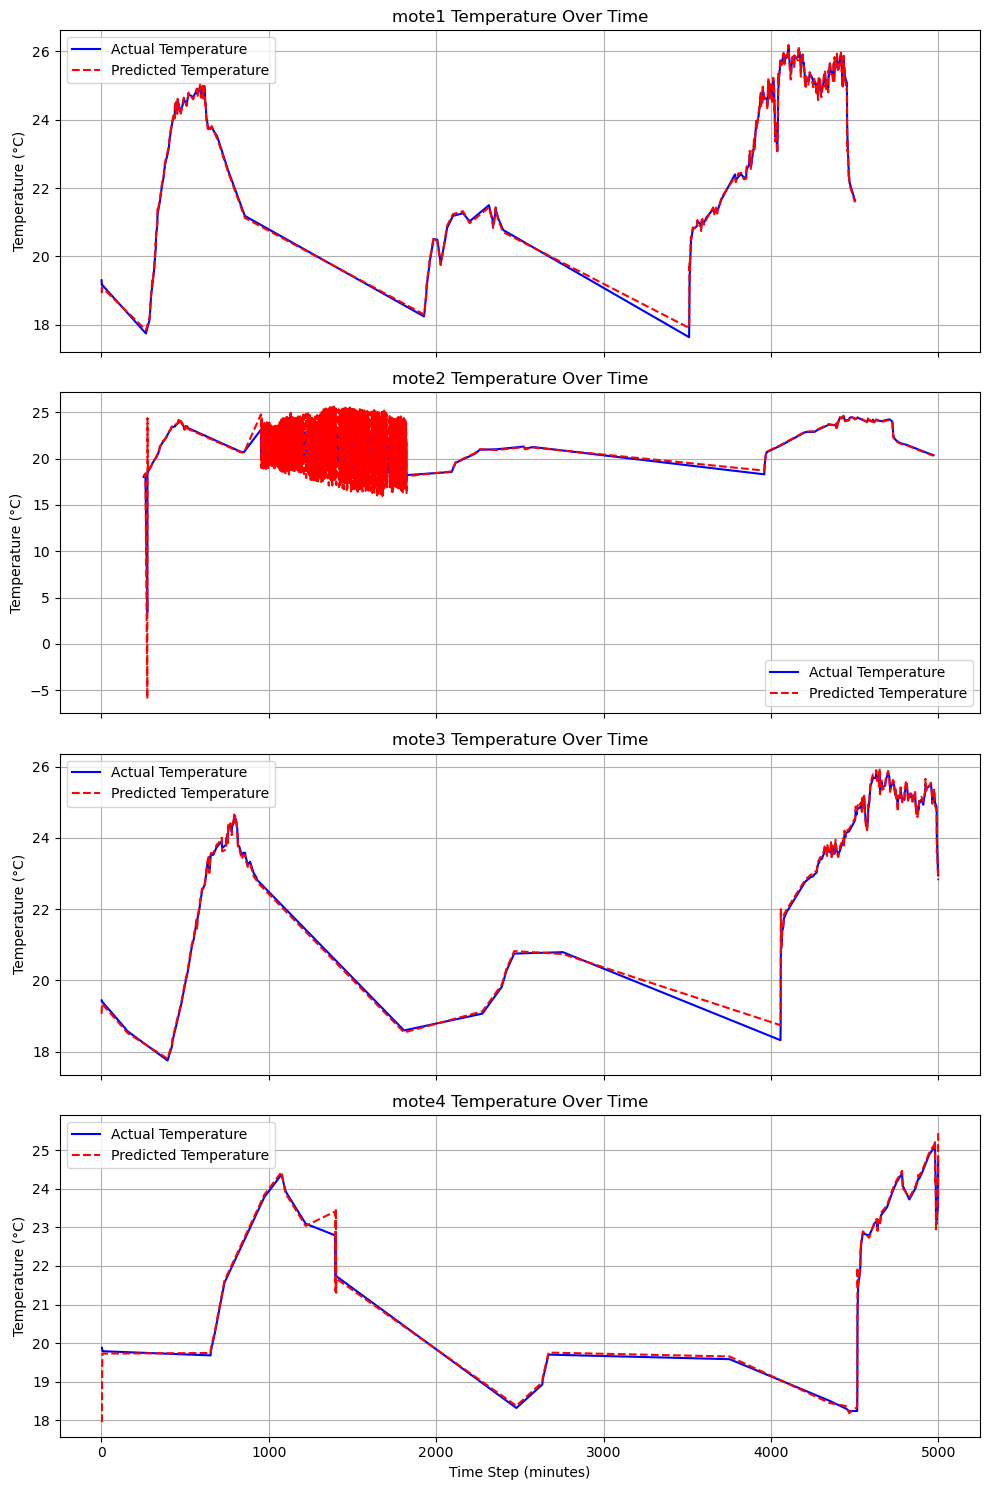

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_four_motes_temperatures.csv')
pivot_df = pivot_df.head(5000)

# Parameters
A = np.array([[1, 1], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0]])                   # Measurement noise covariance
epsilon = 0.05                        # Sensitivity threshold for event detection
theta = 0.05                          # Threshold for significant change
num_nodes_to_poll = 2                 # Number of nodes to poll at each timestep

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize state estimates and rate of change for each mote
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 5)}
P = {f'mote{i}': np.eye(2) * 0 for i in range(1, 5)}

# Initialize previous timestamps for delta time calculation
last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 5)}
last_update_times = {f'mote{i}': 0 for i in range(1, 5)}

# Initialize a list to store the most valuable sensor data and the associated metadata
valuable_sensor_data = []

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 5)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 5)}

# Function to predict node state
def predict_node_state(x_hat, delta_t):
    return A @ x_hat

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, last_sensed_values, num_nodes_to_poll, delta_t_global):
    predicted_values = {mote: predict_node_state(state_estimates[mote], delta_t_global)[0, 0] for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)[:num_nodes_to_poll]
    return top_nodes

# Simulation loop
for idx, row in pivot_df.iterrows():
    current_time_step = idx
    delta_t_global = current_time_step - min(last_update_times.values())

    # Predict the sensor with the most significant changes
    top_sensors = select_top_nodes(state_estimates, last_sensed_values, num_nodes_to_poll, delta_t_global)

    for mote in top_sensors:
        polled_count[mote] += 1
        measured_value = row[mote]
        previous_state = state_estimates[mote]
        previous_P = P[mote]
        delta_t = max(current_time_step - last_update_times[mote], 1)  # Default to 1 if first measurement

        # Prediction step
        xp = A @ previous_state
        Pp = A @ previous_P @ A.T + Q

        # Update step
        z = np.array([[measured_value]])
        K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
        x_hat = xp + K @ (z - H @ xp)
        P_hat = Pp - K @ H @ Pp

        # Store the updated state estimates and covariance matrix
        state_estimates[mote] = x_hat
        P[mote] = P_hat

        predicted_measurement = predict_node_state(x_hat, delta_t)[0, 0]

        if abs(measured_value - predicted_measurement) > theta:
            transmitted_count[mote] += 1
            last_sensed_values[mote] = measured_value

            # Store the data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

    # Update the last selected index for the most valuable mote
    for mote in top_sensors:
        last_update_times[mote] = current_time_step

# Convert the list to a DataFrame
valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

# Calculate the average MSE
valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
average_mse = valuable_sensor_df['squared_error'].mean()
print(f'Average MSE: {average_mse}')

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Plot the actual and predicted temperatures for each mote
fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

for i, mote in enumerate(['mote1', 'mote2', 'mote3', 'mote4']):
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['temperature'], 'b-', label='Actual Temperature')
    axs[i].plot(mote_data['index'], mote_data['predicted_temperature'], 'r--', label='Predicted Temperature')
    axs[i].set_title(f'{mote} Temperature Over Time')
    axs[i].set_ylabel('Temperature (°C)')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()

# Save the DataFrame to a CSV file
valuable_sensor_df.to_csv('valuable_sensor_kal_df.csv', index=False)


Average MSE: 1.2045783479948993
Average sensor lifetime (years): 2.400073279212431


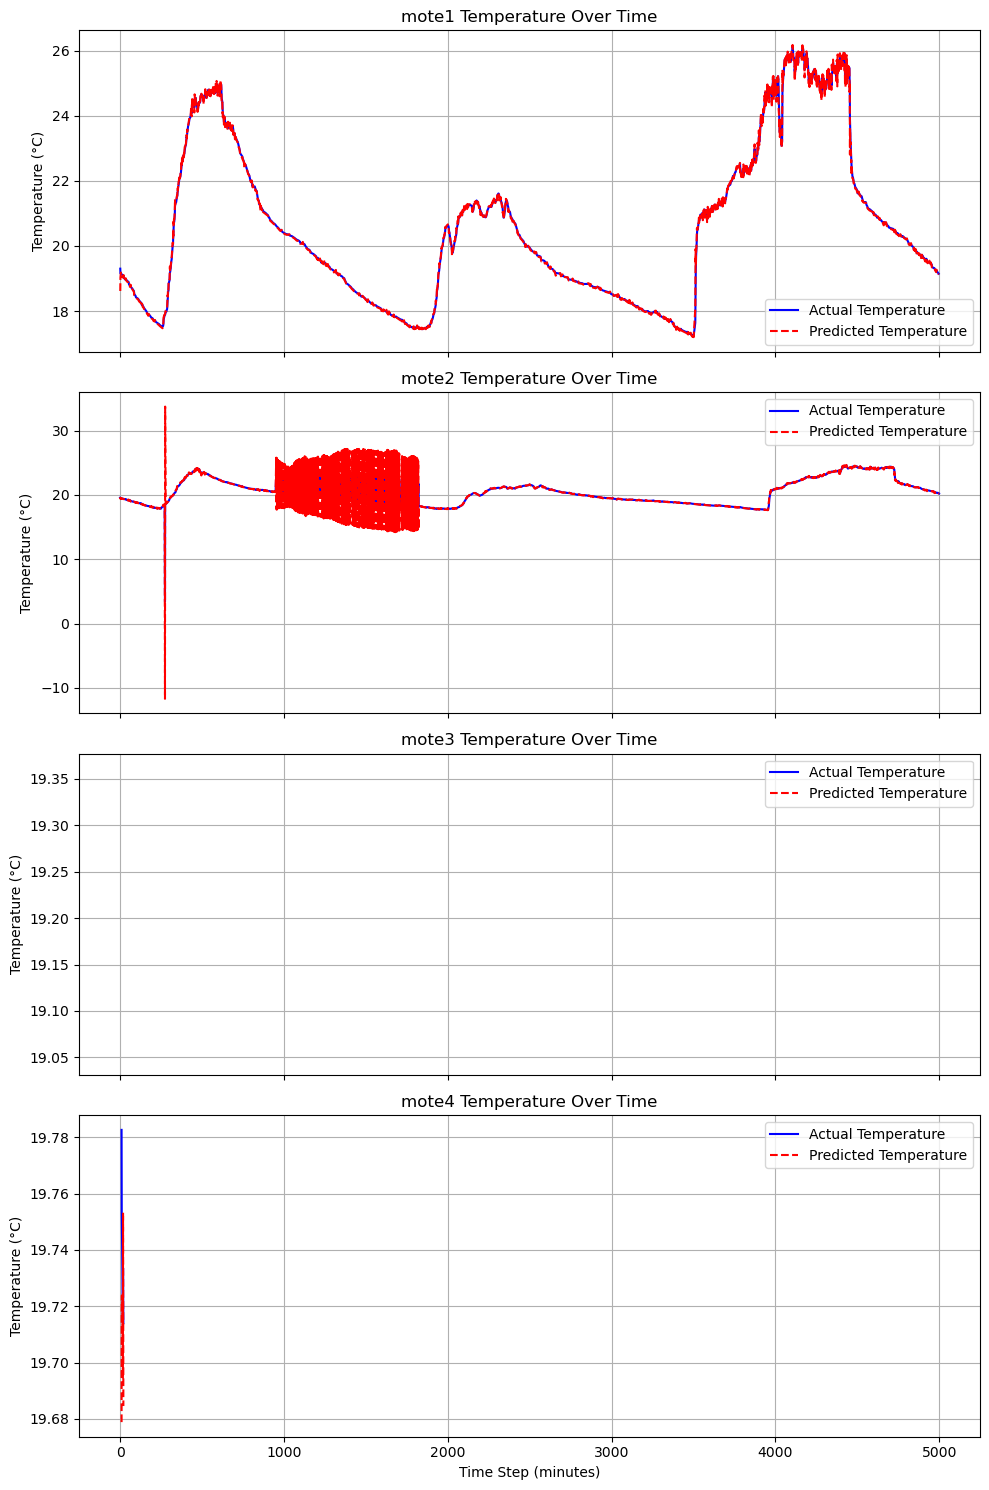

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_four_motes_temperatures.csv')
pivot_df = pivot_df.head(5000)

# Parameters
A = np.array([[1, 1], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[0.001, 0], [0.001, 0]])  # Process noise covariance
R = np.array([[0]])                   # Measurement noise covariance
epsilon = 0.01                        # Sensitivity threshold for event detection
theta = 0.01                          # Threshold for significant change
num_nodes_to_poll = 2                  # Number of nodes to poll at each timestep

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize state estimates and rate of change for each mote
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 5)}
P = {f'mote{i}': np.eye(2) * 6 for i in range(1, 5)}

# Initialize previous timestamps for delta time calculation
last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 5)}
last_update_times = {f'mote{i}': 0 for i in range(1, 5)}

# Initialize a list to store the most valuable sensor data and the associated metadata
valuable_sensor_data = []

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 5)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 5)}

# Function to predict node state
def predict_node_state(x_hat, delta_t):
    return A @ x_hat

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, last_sensed_values, num_nodes_to_poll, delta_t_global, currently_polled_nodes):
    predicted_values = {mote: predict_node_state(state_estimates[mote], delta_t_global)[0, 0] for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)
    # Filter out nodes that are already polled in this iteration
    top_nodes = [node for node in top_nodes if node not in currently_polled_nodes][:num_nodes_to_poll]
    return top_nodes

# Simulation loop
for idx, row in pivot_df.iterrows():
    current_time_step = idx
    delta_t_global = current_time_step - min(last_update_times.values())
    
    currently_polled_nodes = set()

    # Predict the sensor with the most significant changes
    top_sensors = select_top_nodes(state_estimates, last_sensed_values, num_nodes_to_poll, delta_t_global, currently_polled_nodes)

    for mote in top_sensors:
        polled_count[mote] += 1
        measured_value = row[mote]
        previous_state = state_estimates[mote]
        previous_P = P[mote]
        delta_t = max(current_time_step - last_update_times[mote], 1)  # Default to 1 if first measurement

        # Prediction step
        xp = A @ previous_state
        Pp = A @ previous_P @ A.T + Q

        # Update step
        z = np.array([[measured_value]])
        K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
        x_hat = xp + K @ (z - H @ xp)
        P_hat = Pp - K @ H @ Pp

        # Store the updated state estimates and covariance matrix
        state_estimates[mote] = x_hat
        P[mote] = P_hat

        predicted_measurement = predict_node_state(x_hat, delta_t)[0, 0]

        if abs(measured_value - predicted_measurement) > theta:
            transmitted_count[mote] += 1
            last_sensed_values[mote] = measured_value

            # Store the data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        # Mark this node as polled in the current iteration
        currently_polled_nodes.add(mote)

    # Update the last selected index for the most valuable mote
    for mote in top_sensors:
        last_update_times[mote] = current_time_step

# Convert the list to a DataFrame
valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

# Calculate the average MSE
valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
average_mse = valuable_sensor_df['squared_error'].mean()
print(f'Average MSE: {average_mse}')

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Plot the actual and predicted temperatures for each mote
fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

for i, mote in enumerate(['mote1', 'mote2', 'mote3', 'mote4']):
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['temperature'], 'b-', label='Actual Temperature')
    axs[i].plot(mote_data['index'], mote_data['predicted_temperature'], 'r--', label='Predicted Temperature')
    axs[i].set_title(f'{mote} Temperature Over Time')
    axs[i].set_ylabel('Temperature (°C)')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()

# Save the DataFrame to a CSV file
valuable_sensor_df.to_csv('valuable_sensor_df.csv', index=False)


Force pulling mote: mote1 at time step: 200
Force pulling mote: mote4 at time step: 224
Force pulling mote: mote3 at time step: 441
Force pulling mote: mote2 at time step: 444
Force pulling mote: mote1 at time step: 465
Force pulling mote: mote4 at time step: 799
Force pulling mote: mote3 at time step: 801
Force pulling mote: mote1 at time step: 816
Force pulling mote: mote3 at time step: 1102
Force pulling mote: mote2 at time step: 1104
Force pulling mote: mote4 at time step: 1108
Force pulling mote: mote3 at time step: 1303
Force pulling mote: mote2 at time step: 1304
Force pulling mote: mote4 at time step: 1308
Force pulling mote: mote3 at time step: 1503
Force pulling mote: mote2 at time step: 1504
Force pulling mote: mote4 at time step: 1508
Force pulling mote: mote3 at time step: 1703
Force pulling mote: mote2 at time step: 1704
Force pulling mote: mote4 at time step: 1708
Force pulling mote: mote3 at time step: 1903
Force pulling mote: mote2 at time step: 1904
Force pulling mote

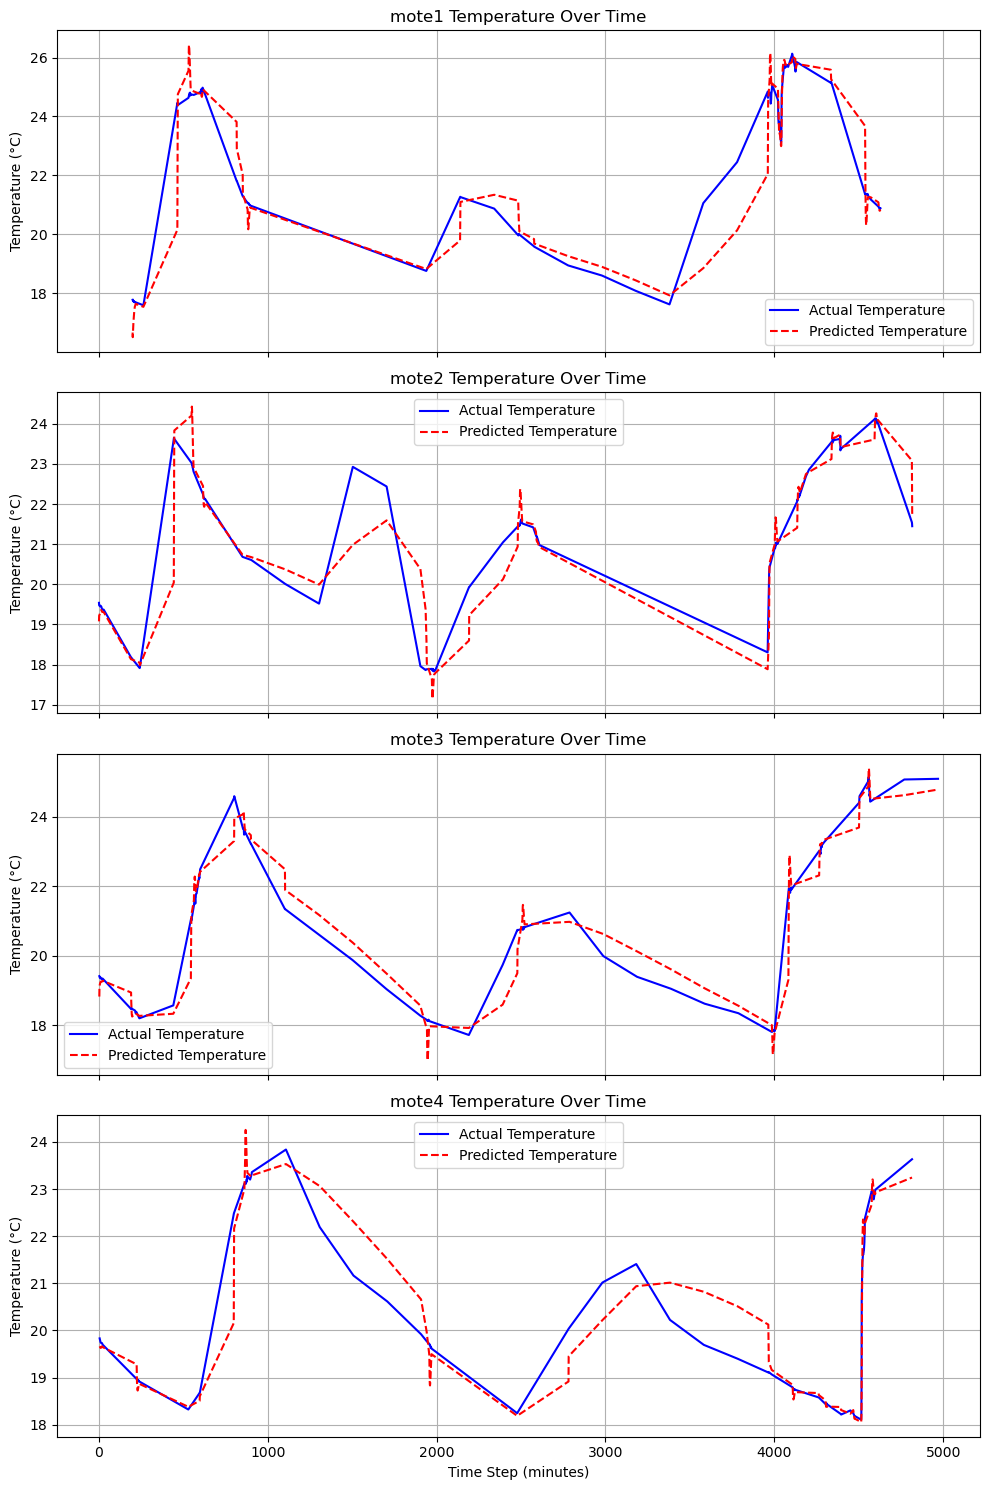

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_four_motes_temperatures.csv')
pivot_df = pivot_df.head(5000)

# Parameters
A = np.array([[1, 32], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.05                        # Sensitivity threshold for event detection
theta = 0.05                          # Threshold for significant change
num_nodes_to_poll = 1                 # Number of nodes to poll at each timestep
force_pull_threshold = 200             # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize state estimates and rate of change for each mote
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 5)}
P = {f'mote{i}': np.eye(2) * 6 for i in range(1, 5)}

# Initialize previous timestamps for delta time calculation
last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 5)}
last_update_times = {f'mote{i}': 0 for i in range(1, 5)}

# Initialize a list to store the most valuable sensor data and the associated metadata
valuable_sensor_data = []

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 5)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 5)}

# Function to predict node state
def predict_node_state(x_hat, delta_t):
    return A @ x_hat

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, last_sensed_values, num_nodes_to_poll, delta_t_global, currently_polled_nodes):
    predicted_values = {mote: predict_node_state(state_estimates[mote], delta_t_global)[0, 0] for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)
    # Filter out nodes that are already polled in this iteration
    top_nodes = [node for node in top_nodes if node not in currently_polled_nodes][:num_nodes_to_poll]
    return top_nodes

# Simulation loop
for idx, row in pivot_df.iterrows():
    current_time_step = idx
    delta_t_global = current_time_step - min(last_update_times.values())
    
    currently_polled_nodes = set()

    # Check if any node needs to be forcefully pulled due to inactivity
    for mote, last_time in last_update_times.items():
        if current_time_step - last_time >= force_pull_threshold:
            currently_polled_nodes.add(mote)
            print(f"Force pulling mote: {mote} at time step: {current_time_step}")

    # Predict the sensor with the most significant changes
    top_sensors = select_top_nodes(state_estimates, last_sensed_values, num_nodes_to_poll, delta_t_global, currently_polled_nodes)

    # Include forced pull nodes in the top sensors list
    top_sensors = list(currently_polled_nodes) + top_sensors

    for mote in top_sensors:
        polled_count[mote] += 1
        measured_value = row[mote]
        previous_state = state_estimates[mote]
        previous_P = P[mote]
        delta_t = max(current_time_step - last_update_times[mote], 1)  # Default to 1 if first measurement

        # Prediction step
        xp = A @ previous_state
        Pp = A @ previous_P @ A.T + Q

        # Update step
        z = np.array([[measured_value]])
        K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
        x_hat = xp + K @ (z - H @ xp)
        P_hat = Pp - K @ H @ Pp

        # Store the updated state estimates and covariance matrix
        state_estimates[mote] = x_hat
        P[mote] = P_hat

        predicted_measurement = predict_node_state(x_hat, delta_t)[0, 0]

        if abs(measured_value - predicted_measurement) > theta:
            transmitted_count[mote] += 1
            last_sensed_values[mote] = measured_value

            # Store the data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        # Mark this node as polled in the current iteration
        currently_polled_nodes.add(mote)

    # Update the last selected index for the most valuable mote
    for mote in top_sensors:
        last_update_times[mote] = current_time_step

# Convert the list to a DataFrame
valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

# Calculate the average MSE
valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
average_mse = valuable_sensor_df['squared_error'].mean()
print(f'Average MSE: {average_mse}')

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Plot the actual and predicted temperatures for each mote
fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

for i, mote in enumerate(['mote1', 'mote2', 'mote3', 'mote4']):
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['temperature'], 'b-', label='Actual Temperature')
    axs[i].plot(mote_data['index'], mote_data['predicted_temperature'], 'r--', label='Predicted Temperature')
    axs[i].set_title(f'{mote} Temperature Over Time')
    axs[i].set_ylabel('Temperature (°C)')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()

# Save the DataFrame to a CSV file
valuable_sensor_df.to_csv('valuable_sensor_df.csv', index=False)
